<a href="https://colab.research.google.com/github/Josh413/Forecasting-Models-UConn-Research-2025-/blob/main/LLM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device set to use cpu


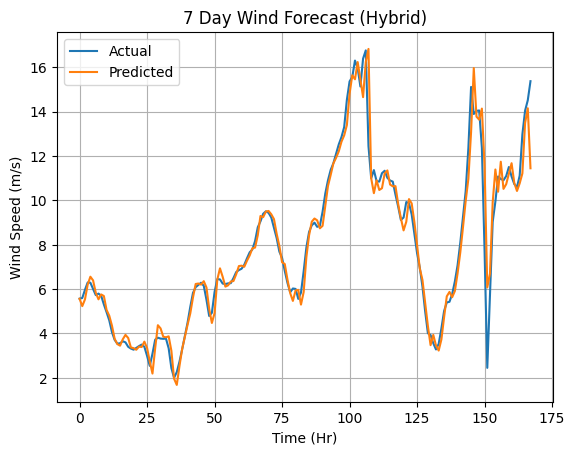

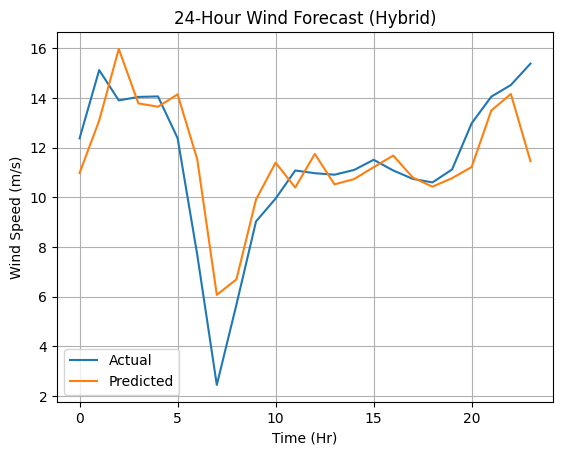

*Actual load data from 2024-12-03 00:00:00
RMSE:  0.764  m/s
MAPE: 5.11%


In [ ]:
#HYBRID(LLAMA-XGBOOST) MODEL[WINDSPEED]
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from transformers import pipeline
import re
import matplotlib.pyplot as plt

df = pd.read_csv('CapeCodWind.csv', skiprows=8, header=1)
df['Time Stamp'] = pd.to_datetime(df[['YEAR','MO','DY','HR']].rename(
    columns={'YEAR':'year','MO':'month','DY':'day','HR':'hour'}))
df = df.set_index('Time Stamp')
df = df.rename(columns={'WS50M': 'wind'})
df = df[['wind']].dropna()

def create_features(df):
    df = df.copy()
    for lag in [1, 2, 3, 6, 12, 24, 48, 72]:
        df[f'lag_{lag}'] = df['wind'].shift(lag)
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    df['doy_sin']  = np.sin(2 * np.pi * df.index.dayofyear / 365)
    df['doy_cos']  = np.cos(2 * np.pi * df.index.dayofyear / 365)
    df['mean_24h'] = df['wind'].rolling(24).mean()
    df['std_24h']  = df['wind'].rolling(24).std()
    return df.dropna()

df_feat = create_features(df)

generator = pipeline('text-generation', model='TinyLlama/TinyLlama-1.1B-Chat-v1.0')

recent= df['wind'].iloc[-224:-24].values
past_values = ', '.join([f'{v:.2f}' for v in recent])
prompt = f'Past wind speeds (m/s): {past_values}. Predict the next 24 wind speeds:'
response = generator(prompt, max_new_tokens=100, do_sample=True, temperature=0.3)

generated_text = response[0]['generated_text']
numbers = re.findall(r"\d+\.\d+", generated_text)
llm_forecast = [float(n) for n in numbers[-24:]]
llm_summary = [np.mean(llm_forecast), np.std(llm_forecast), np.min(llm_forecast), np.max(llm_forecast)]

n_test = 24 * 30
train_df = df_feat.iloc[:-n_test]
test_df  = df_feat.iloc[-n_test:]

X_train = train_df.drop(columns=['wind'])
y_train = train_df['wind']
X_test = test_df.drop(columns=['wind'])
y_test = test_df['wind']

X_test.iloc[-1, :4] = llm_summary

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

model = xgb.train(params, dtrain, num_boost_round=500)

y_pred = model.predict(dtest)

plt.plot(y_test.values[-24*7:], label='Actual')
plt.plot(y_pred[-24*7:], label='Predicted')
plt.title('7-Day Wind Forecast (Hybrid)')
plt.xlabel('Time (Hr)')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid()
plt.show()

plt.plot(y_test.values[-24:], label='Actual')
plt.plot(y_pred[-24:], label='Predicted')
plt.title('24-Hour Wind Forecast (Hybrid)')
plt.xlabel('Time (Hr)')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid()
plt.show()

test_start_index = len(df) - len(y_test)
print('*Actual load data from',df.index[test_start_index])
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f'RMSE:  {rmse:.3f}  m/s')
print(f'MAPE: {mape:.2f}%')


Device set to use cpu


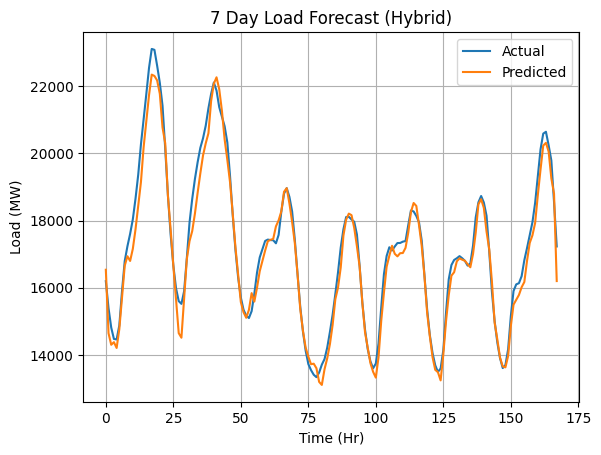

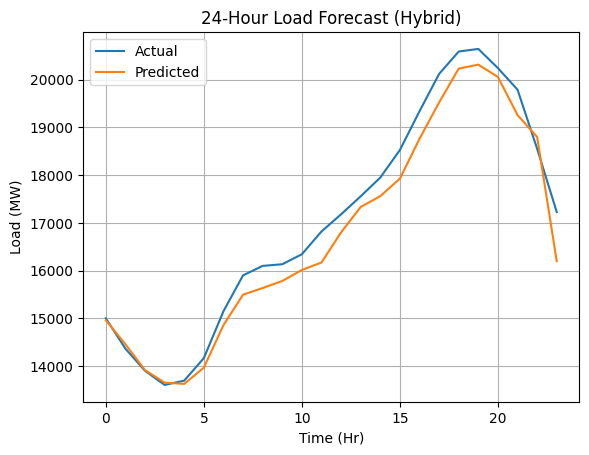

*Actual load data from 2025-05-13 00:00:00
RMSE: 285.036 MW
MAPE: 1.30%


In [ ]:
#HYBRID(LLAMA-XGBOOST) MODEL[LOAD]
import pandas as pd
import numpy as np
import re
from transformers import pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb

df = pd.read_csv('nyiso_loads (1).csv')
df_melted = df.melt(id_vars = ['Year', 'Month', 'Day'],
                  value_vars = [f'Hr{i}' for i in range (1,25)],
                  var_name = 'HourTitle', value_name = 'Load')
df_melted['Hour'] = df_melted['HourTitle'].str.extract('Hr(\d+)').astype(int)-1
df_melted['Time Stamp'] = (
    (pd.to_datetime(df_melted[['Year', 'Month', 'Day']]) +
                   pd.to_timedelta(df_melted['Hour'], unit = 'h')))
df_final = df_melted[['Time Stamp', 'Load']].sort_values('Time Stamp').set_index('Time Stamp').sort_index()

def create_features(df_final):
    df_final = df_final.copy()
    for lag in [1, 2, 3, 6, 12, 24, 48, 72]:
        df_final[f'lag_{lag}'] = df_final['Load'].shift(lag)
    df_final['hour_sin'] = np.sin(2 * np.pi * df_final.index.hour / 24)
    df_final['hour_cos'] = np.cos(2 * np.pi * df_final.index.hour / 24)
    df_final['doy_sin']  = np.sin(2 * np.pi * df_final.index.dayofyear / 365)
    df_final['doy_cos']  = np.cos(2 * np.pi * df_final.index.dayofyear / 365)
    df_final['mean_24h'] = df_final['Load'].rolling(24).mean()
    df_final['std_24h']  = df_final['Load'].rolling(24).std()
    return df_final.dropna()

df_final_feat = create_features(df_final)

generator = pipeline('text-generation', model = 'TinyLlama/TinyLlama-1.1B-Chat-v1.0')
recent = df_final['Load'].iloc[-224:-24].values
past_values = ', '.join([f'{v:.2f}' for v in recent])
prompt = f'Past load (MW): {past_values}. Predict the next 24 load values'
response = generator(prompt, max_new_tokens=100, do_sample=True, temperature=0.3)

generated_text = response[0]['generated_text']
numbers = re.findall(r"\d+\.\d+", generated_text)
llm_forecast = [float(n) for n in numbers[-24:]]
llm_summary = [np.mean(llm_forecast), np.std(llm_forecast), np.min(llm_forecast), np.max(llm_forecast)]

n_test = 24*30
train_df_final = df_final_feat.iloc[:-n_test]
test_df_final = df_final_feat.iloc[-n_test:]

X_train = train_df_final.drop(columns=['Load'])
y_train = train_df_final['Load']
X_test = test_df_final.drop(columns=['Load'])
y_test = test_df_final['Load']

X_test.iloc[-1, :4] = llm_summary

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

params = {
    'objective' : 'reg:squarederror',
    'learning_rate' : 0.05,
    'max_depth' : 4,
    'subsample' : 0.8,
    'colsample_bytree' : 0.8
}

model = xgb.train(params, dtrain, num_boost_round=5000)

y_pred = model.predict(dtest)

plt.plot(y_test.values[-24*7:], label = 'Actual')
plt.plot(y_pred[-24*7:], label = 'Predicted')
plt.title('7-Day Load Forecast (Hybrid)')
plt.xlabel('Time (Hr)')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid()
plt.show()

plt.plot(y_test.values[-24:], label = 'Actual')
plt.plot(y_pred[-24:], label = 'Predicted')
plt.title('24-Hour Load Forecast (Hybrid)')
plt.xlabel('Time (Hr)')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid()
plt.show()

test_start_index = len(df_final)-len(y_test)
print(f'*Actual load data from {df_final.index[test_start_index]}')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test,y_pred)*100
print(f'RMSE: {rmse:.3f} MW')
print(f'MAPE: {mape:.2f}%')





Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Past load (MW): 20589.00, 20733.00, 20363.00, 19859.00, 18657.00, 17289.00, 16194.00, 15391.00, 14811.00, 14472.00, 14457.00, 14877.00, 15900.00, 16792.00, 17232.00, 17603.00, 18035.00, 18654.00, 19365.00, 20262.00, 21003.00, 21770.00, 22546.00, 23111.00, 23084.00, 22614.00, 22100.00, 21420.00, 2014...


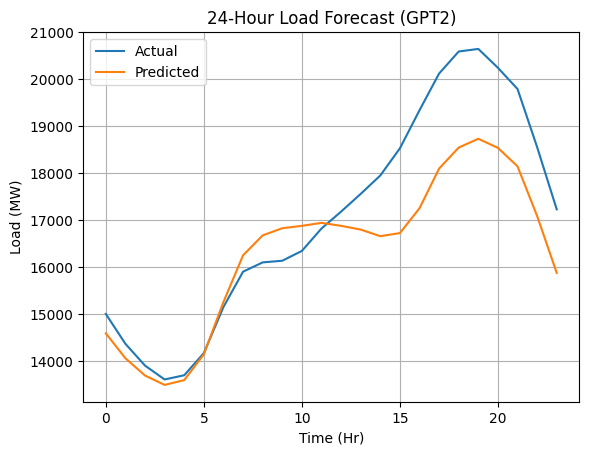

*Actual load data from 2025-06-11 00:00:00
RMSE:  1173.725  MW
MAPE: 4.94%


In [25]:
#GPT2 MODEL[LOAD]
import pandas as pd
from transformers import pipeline
import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

df = pd.read_csv('nyiso_loads (1).csv')
df_melted = df.melt(id_vars = ['Year', 'Month', 'Day'],
                    value_vars=[f'Hr{i}' for i in range (1,25)],
                    var_name = 'HourTitle', value_name='Load')
df_melted = df_melted.dropna(subset=['Load'])
df_melted['Hour'] = df_melted['HourTitle'].str.extract('Hr(\d+)').astype(int) - 1
df_melted['Time Stamp'] = (pd.to_datetime(df_melted[['Year', 'Month', 'Day']]) +
                           pd.to_timedelta(df_melted['Hour'], unit = 'h'))
df_final = df_melted[['Time Stamp', 'Load']].sort_values('Time Stamp').set_index('Time Stamp').sort_index()

history_len = 150
target_len = 24

generator = pipeline('text-generation', model = 'gpt2')
recent_data = df_final['Load'].iloc[-(history_len+target_len):].values
past_values = ', '.join([f'{v:.2f}' for v in recent_data[:history_len]])
prompt = f'Past load (MW): {past_values}. Predict the next 24 load values'
print(prompt[:300]+'...')
response = generator(prompt, max_new_tokens = 100, do_sample = True, temperature = 0.3)
generated_text = response[0]['generated_text']
output = generated_text.split("Output:")[-1]
numbers = re.findall(r'\d+\.\d+', output)
predicted = [float(n) for n in numbers[-24:]]
actual = recent_data[-24:]

plt.plot(actual, label = 'Actual')
plt.plot(predicted, label = 'Predicted')
plt.title('24-Hour Load Forecast (GPT2)')
plt.xlabel('Time (Hr)')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid()
plt.show()

test_start_index = len(df_final) - 24
print(f'*Actual load data from {df_final.index[test_start_index]}')
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = mean_absolute_percentage_error(actual, predicted) * 100
print(f'RMSE:  {rmse:.3f}  MW')
print(f'MAPE: {mape:.2f}%')



Past wind speeds (m/s): 3.36, 4.07, 4.86, 5.75, 6.55, 7.22, 7.61, 7.74, 7.69, 7.36, 6.96, 6.60, 6.79, 7.24, 7.65, 8.21, 8.58, 8.97, 8.94, 8.60, 7.79, 6.93, 6.23, 6.03, 6.41, 6.86, 7.57, 8.28, 8.73, 8.85, 8.82, 8.78, 8.62, 8.42, 8.28, 8.28, 8.43, 8.65, 8.81, 8.75, 8.47, 8.21, 8.02, 7.98, 8.05, 8.01, ...


Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Past wind speeds (m/s): 3.36, 4.07, 4.86, 5.75, 6.55, 7.22, 7.61, 7.74, 7.69, 7.36, 6.96, 6.60, 6.79, 7.24, 7.65, 8.21, 8.58, 8.97, 8.94, 8.60, 7.79, 6.93, 6.23, 6.03, 6.41, 6.86, 7.57, 8.28, 8.73, 8.85, 8.82, 8.78, 8.62, 8.42, 8.28, 8.28, 8.43, 8.65, 8.81, 8.75, 8.47, 8.21, 8.02, 7.98, 8.05, 8.01, 7.79, 7.51, 7.59, 7.76, 7.85, 7.72, 7.31, 6.76, 6.31, 5.92, 5.57, 5.60, 5.97, 6.30, 6.29, 6.01, 5.73, 5.80, 5.70, 5.31, 4.96, 4.59, 4.06, 3.71, 3.54, 3.56, 3.65, 3.60, 3.40, 3.32, 3.27, 3.35, 3.43, 3.50, 3.40, 2.99, 2.54, 3.09, 3.72, 3.81, 3.77, 3.76, 3.77, 3.33, 2.44, 2.00, 2.26, 2.73, 3.29, 3.90, 4.49, 5.20, 5.83, 6.09, 6.19, 6.29, 6.15, 5.52, 4.79, 4.93, 5.87, 6.45, 6.44, 6.25, 6.23, 6.26, 6.27, 6.50, 6.77, 6.86, 6.92, 7.10, 7.39, 7.66, 7.79, 8.17, 8.79, 9.06, 9.40, 9.51, 9.44, 9.23, 8.77, 8.30, 7.69, 7.41, 6.82, 6.28, 5.86, 6.03, 6.01, 5.56, 5.84, 6.81, 7.88, 8.58, 8.88, 9.00, 8.81, 8.86, 9.49, 10.31, 10.91, 11.38, 11.68, 12.11, 12.53, 12.86, 13.31, 14.54, 15.37, 15.

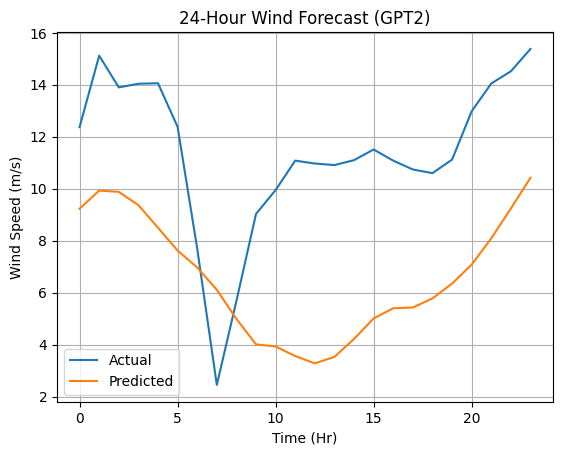

*Actual load data from 2025-06-11 00:00:00
RMSE:  5.374  m/s
MAPE: 48.19%


In [24]:
#GPT2 MODEL[WINDSPEED]
import pandas as pd
from transformers import pipeline
import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

df = pd.read_csv('CapeCodWind.csv', skiprows=8, header=1)
df['Time Stamp'] = pd.to_datetime(df[['YEAR','MO','DY','HR']].rename(
    columns={'YEAR':'year','MO':'month','DY':'day','HR':'hour'}))
df = df.set_index('Time Stamp')
df = df.rename(columns={'WS50M': 'wind'})
df = df[['wind']].dropna()

history_len = 200
target_len = 24

recent_data = df['wind'].iloc[-(history_len+target_len):].values
past_values = ', '.join([f'{v:.2f}' for v in recent_data[:history_len]])
prompt = f'Past wind speeds (m/s): {past_values}. Predict the next 24 wind speeds:'

print(prompt[:300]+'...')

generator = pipeline('text-generation', model ='gpt2')
response=generator(prompt, max_new_tokens=100, temperature=0.3, do_sample=True)
print(response)

generated_text = response[0]['generated_text']
output = generated_text.split("Output:")[-1]
numbers = re.findall(r'\d+\.\d+', output)
predicted = [float(n) for n in numbers[-24:]]

actual=recent_data[-24:]
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.title('24-Hour Wind Forecast (GPT2)')
plt.xlabel('Time (Hr)')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid()
plt.show()

test_start_index = len(df_final) - 24
print(f'*Actual load data from {df_final.index[test_start_index]}')
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = mean_absolute_percentage_error(actual, predicted) * 100
print(f'RMSE:  {rmse:.3f}  m/s')
print(f'MAPE: {mape:.2f}%')